In [28]:
"""
Executable end-to-end ML pipeline using sklearn Iris dataset.
Simulates solutions for:
1. I/O bottlenecks (compact dataset)
2. Feature duplication (feature store reuse)
3. Slow sweeps (Optuna tuning)
4. Dataset lineage (log dataset version)
5. Model governance (MLflow registry)
"""
#pip install scikit-learn optuna mlflow pandas
import mlflow
from mlflow.tracking import MlflowClient
import mlflow.sklearn
import optuna
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mlflow.models.signature import infer_signature
import pandas as pd
import warnings
warnings.filterwarnings("ignore", message=".*")

# === Configuration ===
MODEL_NAME = "iris_rf_model"
DATASET_VERSION = "iris_v1" 
MLFLOW_EXPERIMENT = "iris_mlflow_experiment"

# Set remote/local MLflow tracking server
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment(MLFLOW_EXPERIMENT)
client = MlflowClient()

# -----------------------------------------------------------
# 1. FIX I/O bottlenecks (simulate compact dataset)
# -----------------------------------------------------------
iris = load_iris(as_frame=True)
df = iris.frame.copy()
df["target"] = iris.target
# Instead of many small files, keep one clean DataFrame
print(f"Dataset compacted: {df.shape[0]} rows, {df.shape[1]} columns")

# -----------------------------------------------------------
# 2. FIX DUPLICATE FEATURES (simulate "Feature Store" by reusable feature DataFrame)
# -----------------------------------------------------------

def create_feature_store(df: pd.DataFrame) -> pd.DataFrame:
    feature_df = df.copy()
    feature_df["sepal_area"] = df["sepal length (cm)"] * df["sepal width (cm)"]
    feature_df["petal_area"] = df["petal length (cm)"] * df["petal width (cm)"]
    return feature_df

feature_store_df = create_feature_store(df)
print(feature_store_df.info())
# Reuse features in training
X = feature_store_df.drop(columns=["target"])
y = feature_store_df["target"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -----------------------------------------------------------
# 3. FIX SLOW SWEEPS (Optuna hyperparameter tuning)
# -----------------------------------------------------------
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_train, y_train)
    preds = clf.predict(X_val)
    return accuracy_score(y_val, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5, n_jobs=1)
best_params = study.best_params
print("Optuna hyperparameter tuning - Best params found:", best_params)

# Prepare model schema
input_example = X_train.iloc[:2]
signature = infer_signature(X_train, final_model.predict(X_train))

# -----------------------------------------------------------
# 4 & 5. FIX LINEAGE + GOVERNANCE (MLflow registry)
# -----------------------------------------------------------
with mlflow.start_run() as run:
    # Log dataset lineage
    mlflow.set_tag("dataset_version", DATASET_VERSION)
    mlflow.set_tag("feature_table", "models")

    # Train final model
    final_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
    final_model.fit(X_train, y_train)
    preds = final_model.predict(X_val)
    acc = accuracy_score(y_val, preds)

    mlflow.log_metric("val_accuracy", acc)
    mlflow.log_params(best_params)

    # Log + Register Model
    mlflow.sklearn.log_model(
    sk_model=final_model,
    name="model",
    #registered_model_name=MODEL_NAME, # directly registers it but misses tag without latest version from DB
    input_example=input_example,
    signature=signature
    )
    
    # Build URI after logging
    model_uri = f"runs:/{run.info.run_id}/model"
    # Register model in MLflow Registry
    mv = mlflow.register_model(model_uri=model_uri, name=MODEL_NAME)
    
    # Add Governance/lineage tags
    client.set_model_version_tag(MODEL_NAME, mv.version, "owner", "ml_team")
    client.set_model_version_tag(MODEL_NAME, mv.version, "dataset_version", DATASET_VERSION)
    client.set_model_version_tag(MODEL_NAME, mv.version, "feature_table", "iris_feature_store")

# Promote to Staging # Remove this if no DB registry available
# client.transition_model_version_stage(
#     name=MODEL_NAME,
#     version=mv.version,
#     stage="Staging"
# )

print(f"✅ Model {MODEL_NAME} version {mv.version} logged with accuracy={acc:.4f}")


[I 2025-09-10 16:21:05,320] A new study created in memory with name: no-name-9a98d1ab-ad1c-498a-a30f-1f9cdda28115


Dataset compacted: 150 rows, 5 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
 5   sepal_area         150 non-null    float64
 6   petal_area         150 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 8.3 KB
None


[I 2025-09-10 16:21:05,719] Trial 0 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 150, 'max_depth': 13}. Best is trial 0 with value: 0.9333333333333333.
[I 2025-09-10 16:21:06,054] Trial 1 finished with value: 0.9666666666666667 and parameters: {'n_estimators': 184, 'max_depth': 2}. Best is trial 1 with value: 0.9666666666666667.
[I 2025-09-10 16:21:06,178] Trial 2 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 53, 'max_depth': 14}. Best is trial 1 with value: 0.9666666666666667.
[I 2025-09-10 16:21:06,269] Trial 3 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 28, 'max_depth': 17}. Best is trial 1 with value: 0.9666666666666667.
[I 2025-09-10 16:21:06,640] Trial 4 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 154, 'max_depth': 8}. Best is trial 1 with value: 0.9666666666666667.


Optuna hyperparameter tuning - Best params found: {'n_estimators': 184, 'max_depth': 2}


Registered model 'iris_rf_model' already exists. Creating a new version of this model...
2025/09/10 16:21:11 WARNING mlflow.tracking._model_registry.fluent: Run with id 4ddbaf090ee34323b26ae4fae454a335 has no artifacts at artifact path 'model', registering model based on models:/m-0277e723bcec480ba2150279ea9fcbb7 instead
2025/09/10 16:21:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: iris_rf_model, version 17
Created version '17' of model 'iris_rf_model'.


🏃 View run zealous-donkey-57 at: http://127.0.0.1:5000/#/experiments/204415308566175607/runs/4ddbaf090ee34323b26ae4fae454a335
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/204415308566175607
✅ Model iris_rf_model version 17 logged with accuracy=0.9667


## MLflow Experiment page
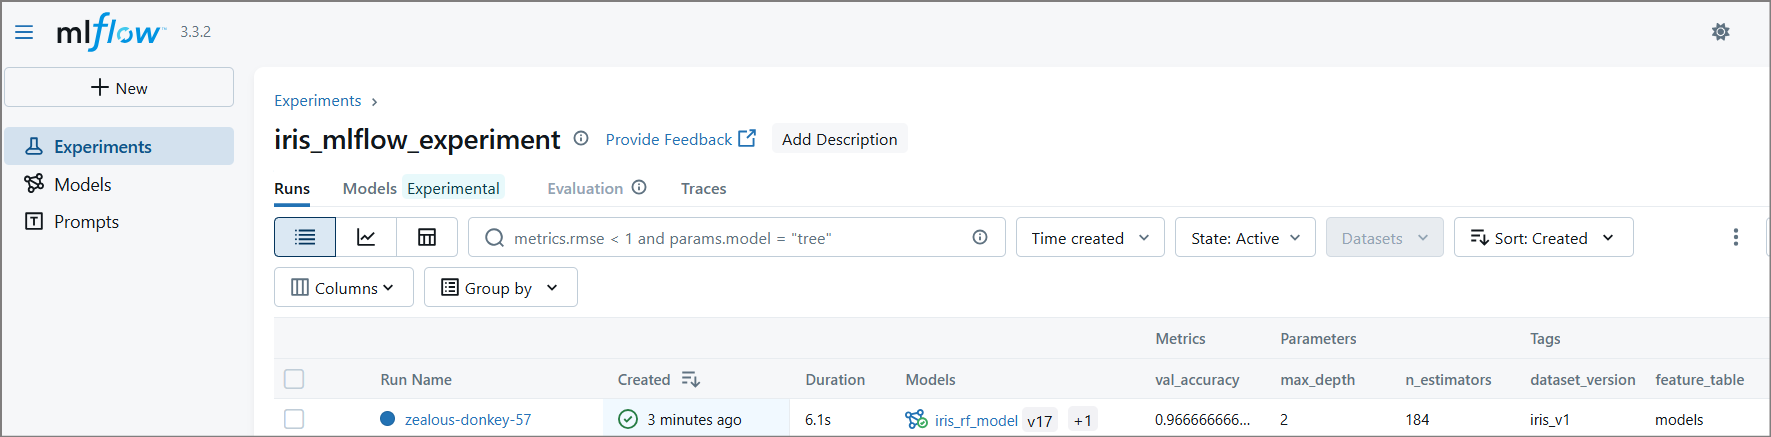
## MLflow Model page
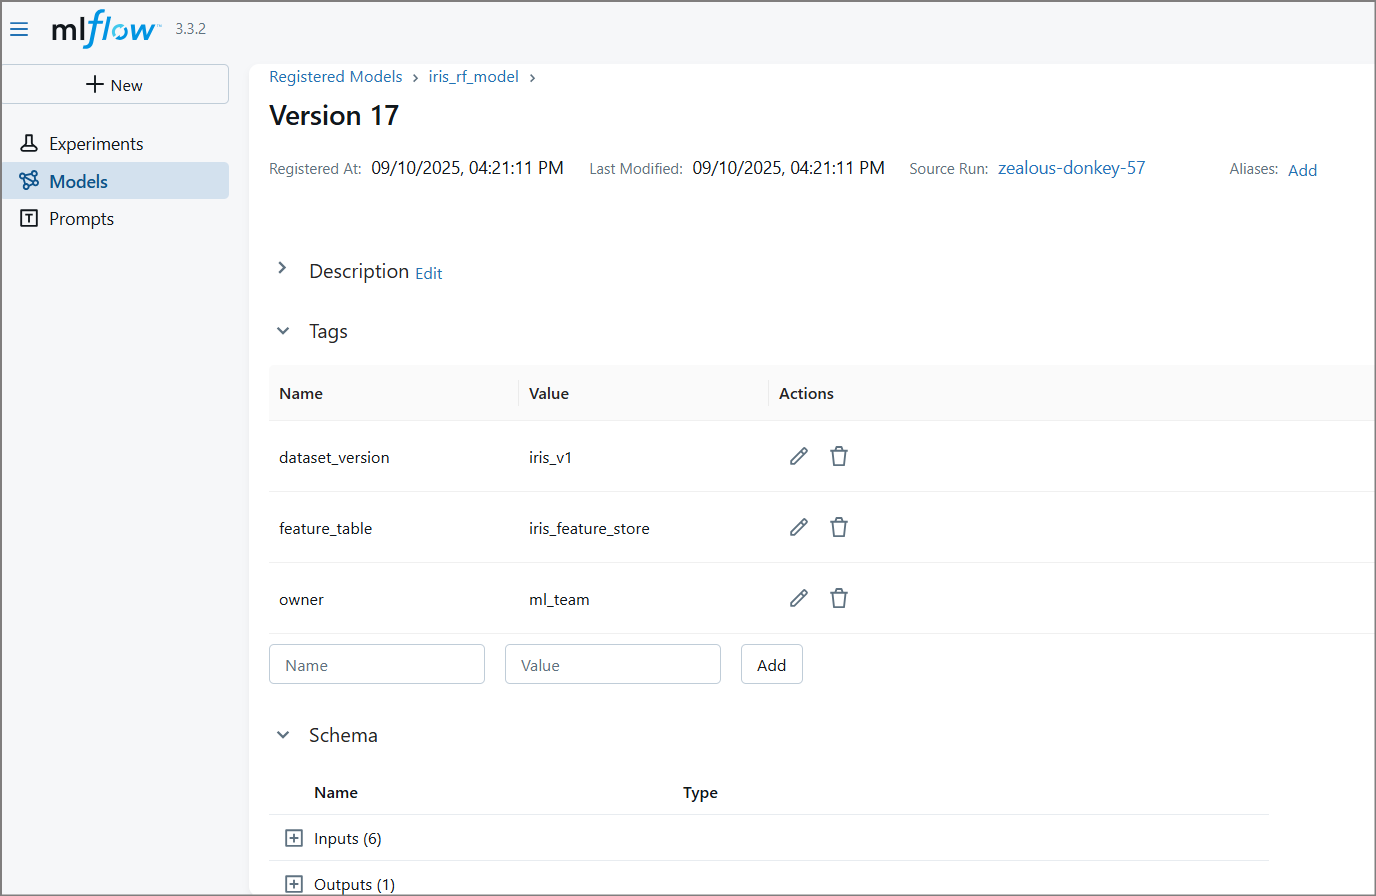